In [45]:
# Wheter or not we are executing on Google Colab
drive = False

# Only needed it the code is executed on Colab
if drive:
    from google.colab import drive
    drive.mount('/content/drive')
    !pip install tabulate

# STGCN-PyTorch

## Packages

In [46]:
import random
import torch
import copy
import os
import json
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tabulate import tabulate

## Load data

In [47]:
# Loads a matrix from a CSV file, skipping the first line and compressing numbers to float
def load_matrix(file_path):
    return pd.read_csv(file_path, header=None, skiprows=1).values.astype(float)

# Loads data from a CSV file, removing the 'year' column and splitting data into train, validation and test
def load_data(file_path, len_train, len_val):
    df = pd.read_csv(file_path, header=0).drop(['year'], axis=1).values.astype(float)
    train = df[: len_train]
    val = df[len_train: len_train + len_val]
    test = df[len_train + len_val:]
    return train, val, test

# Transforms data to prepare input (x) and output (y) sets to be fed to the model
def data_transform(data, n_his, n_pred, device):
    n_year = data.shape[0]
    n_route = data.shape[1]
    n_slot = n_year - n_his - n_pred + 1

    x = np.zeros([n_slot, 1, n_his, n_route])
    y = np.zeros([n_slot, n_route])
    for i in range(n_slot):
        x[i, :, :, :] = data[i:i + n_his].reshape(1, n_his, n_route)
        y[i] = data[i + n_his + n_pred - 1]
    return torch.Tensor(x).to(device), torch.Tensor(y).to(device)

# Transforms data to explore input (x) and output (y) sets to be fed to the model
def data_transform_explore(data, n_his, n_pred, device):
    n_year = data.shape[0]
    n_route = data.shape[1]
    n_slot = n_year - n_his - n_pred + 1

    x = np.zeros([n_slot, 1, n_his, n_route])
    y = np.zeros([n_slot, n_route])
    for i in range(n_slot):
        x[i, :, :, :] = data[i:i + n_his].reshape(1, n_his, n_route)
        y[i] = data[i + n_his + n_pred - 1]
    # return x, y
    return torch.tensor(x, dtype=torch.double).to(device), torch.tensor(y, dtype=torch.double).to(device)

# Computes the weighted adyacency matrix W based on distance
def calculate_adjacency_matrix(distances, sigma_squared=10, epsilon=0.5):
    """
    Computes the weighted adyacency matrix W based on distance
    Args:
    distances (np.ndarray): Distance matrix with shape (N, N).
    sigma_squared (float): Value of sigma squared to compute weights.
    epsilon (float): Threshold to determine if a weight is enough to be included in the matrix.
    Returns:
    np.ndarray: The weighted adyacency matrix W.
    """
    N = distances.shape[0]
    W = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                weight = np.exp(-distances[i, j]**2 / sigma_squared)
                if weight >= epsilon:
                    W[i, j] = weight

    return W


## STGCN model

Architecture of the STGCN model, adapted to our dataset.

In [48]:
# stgcn

import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

class align(nn.Module):
    def __init__(self, c_in, c_out):
        super(align, self).__init__()
        self.c_in = c_in
        self.c_out = c_out
        if c_in > c_out:
            self.conv1x1 = nn.Conv2d(c_in, c_out, 1)

    def forward(self, x):
        if self.c_in > self.c_out:
            return self.conv1x1(x)
        if self.c_in < self.c_out:
            return F.pad(x, [0, 0, 0, 0, 0, self.c_out - self.c_in, 0, 0])
        return x

class temporal_conv_layer(nn.Module):
    def __init__(self, kt, c_in, c_out, act="relu"):
        super(temporal_conv_layer, self).__init__()
        self.kt = kt
        self.act = act
        self.c_out = c_out
        self.align = align(c_in, c_out)
        if self.act == "GLU":
            self.conv = nn.Conv2d(c_in, c_out * 2, (kt, 1), 1)
        else:
            self.conv = nn.Conv2d(c_in, c_out, (kt, 1), 1)

    def forward(self, x):
        x_in = self.align(x)[:, :, self.kt - 1:, :]
        if self.act == "GLU":
            x_conv = self.conv(x)
            return (x_conv[:, :self.c_out, :, :] + x_in) * torch.sigmoid(x_conv[:, self.c_out:, :, :])
        if self.act == "sigmoid":
            return torch.sigmoid(self.conv(x) + x_in)
        return torch.relu(self.conv(x) + x_in)

class spatio_conv_layer(nn.Module):
    def __init__(self, ks, c, Lk):
        super(spatio_conv_layer, self).__init__()
        self.Lk = Lk
        self.theta = nn.Parameter(torch.FloatTensor(c, c, ks))
        self.b = nn.Parameter(torch.FloatTensor(1, c, 1, 1))
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.theta, a=math.sqrt(5))
        fan_in, _ = init._calculate_fan_in_and_fan_out(self.theta)
        bound = 1 / math.sqrt(fan_in)
        init.uniform_(self.b, -bound, bound)

    def forward(self, x):
        x_c = torch.einsum("knm,bitm->bitkn", self.Lk, x)
        x_gc = torch.einsum("iok,bitkn->botn", self.theta, x_c) + self.b
        return torch.relu(x_gc + x)

class st_conv_block(nn.Module):
    def __init__(self, ks, kt, n, c, p, Lk):
        super(st_conv_block, self).__init__()
        self.tconv1 = temporal_conv_layer(kt, c[0], c[1], "GLU")
        self.sconv = spatio_conv_layer(ks, c[1], Lk)
        self.tconv2 = temporal_conv_layer(kt, c[1], c[2])
        self.ln = nn.LayerNorm([n, c[2]])
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_s = self.sconv(x_t1)
        x_t2 = self.tconv2(x_s)
        x_ln = self.ln(x_t2.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        return self.dropout(x_ln)

class fully_conv_layer(nn.Module):
    def __init__(self, c):
        super(fully_conv_layer, self).__init__()
        self.conv = nn.Conv2d(c, 1, 1)

    def forward(self, x):
        return self.conv(x)

class output_layer(nn.Module):
    def __init__(self, c, T, n):
        super(output_layer, self).__init__()
        self.tconv1 = temporal_conv_layer(T, c, c, "GLU")
        self.ln = nn.LayerNorm([n, c])
        self.tconv2 = temporal_conv_layer(1, c, c, "sigmoid")
        self.fc = fully_conv_layer(c)

    def forward(self, x):
        x_t1 = self.tconv1(x)
        x_ln = self.ln(x_t1.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x_t2 = self.tconv2(x_ln)
        return self.fc(x_t2)

class STGCN(nn.Module):
    def __init__(self, ks, kt, bs, T, n, Lk, p):
        super(STGCN, self).__init__()
        self.st_conv1 = st_conv_block(ks, kt, n, bs[0], p, Lk)
        self.st_conv2 = st_conv_block(ks, kt, n, bs[1], p, Lk)
        self.output = output_layer(bs[1][2], T - 4 * (kt - 1), n)

    def forward(self, x):
        x_st1 = self.st_conv1(x)
        x_st2 = self.st_conv2(x_st1)
        return self.output(x_st2)


## Utils

In [81]:
import torch
import numpy as np

# Computes scaled Laplacian of an adjacency matrix
def scaled_laplacian(A):
    """
    Computes scaled Laplacian of an adjacency matrix.

    Args:
    A (numpy.ndarray): Adjacency matrix.

    Returns:
    numpy.ndarray: Scaled Laplacian.
    """
    n = A.shape[0]
    d = np.sum(A, axis=1)  # Sum of each row (degree of each node)
    L = np.diag(d) - A  # Non-scaled Laplacian

    # Scaling the Laplacian
    for i in range(n):
        for j in range(n):
            if d[i] > 0 and d[j] > 0:
                L[i, j] /= np.sqrt(d[i] * d[j])

    # Computing the max value of the eigenvalues
    lam = np.linalg.eigvals(L).max().real

    # Returning the scales Laplacian
    return 2 * L / lam - np.eye(n)

# Computes Chebyshev polynomials up to degree Ks for laplacian L
def cheb_poly(L, Ks):
    """
    Computes Chebyshev polynomials up to degree Ks for laplacian L.

    Args:
    L (numpy.ndarray): Scaled Laplacian.
    Ks (int): Max degree of Chebyshev polynomials.

    Returns:
    numpy.ndarray: The Chebyshev polynomials.
    """
    n = L.shape[0]
    LL = [np.eye(n), L[:]]  # T_0(L) = I y T_1(L) = L

    # Computing T_k(L) = 2L * T_{k-1}(L) - T_{k-2}(L)
    for i in range(2, Ks):
        LL.append(np.matmul(2 * L, LL[-1]) - LL[-2])

    return np.asarray(LL)

# Evaluates the model on a data set
def evaluate_model(model, loss, data_iter):
    """
    Evaluates the model on a data set.

    Args:
    model (torch.nn.Module): Model to be evaluated.
    loss (function): Loss function.
    data_iter (iterable): Data iterator.

    Returns:
    float: Average loss.
    """
    model.eval() # Setting the model in evaluation mode
    l_sum, n = 0.0, 0

    with torch.no_grad(): # Turning off gradients calculus
        for x, y in data_iter:
            y_pred = model(x).view(len(x), -1)  # Model prediction
            l = loss(y_pred, y) # Loss
            l_sum += l.item() * y.shape[0] # Accumulating the loss
            n += y.shape[0] # Number of examples

    return l_sum / n # Average loss

# Evaluates the model wrt MAE, MAPE and RMSE 
def evaluate_metric(model, data_iter, scaler):
    """
    Evaluates the model wrt MAE, MAPE and RMSE.

    Args:
    model (torch.nn.Module): Model to be evaluated.
    data_iter (iterable): Data iterator.
    scaler (scaler object): Objet to de-scale data.

    Returns:
    tuple: MAE, MAPE and RMSE metrics.
    """
    model.eval() # Setting the model in evaluation mode

    with torch.no_grad(): # Turning off gradients calculus
        mae, mape, mse = [], [], []

        for x, y in data_iter:
            # De-scale ground truth and predictions
            y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)
            y_pred = scaler.inverse_transform(model(x).view(len(x), -1).cpu().numpy()).reshape(-1)

            d = np.abs(y - y_pred) # Absolute error
            mae += d.tolist() # Accumulating MAE
            mape += (d / y).tolist() # Accumulating MAE
            mse += (d ** 2).tolist() # Accumulating MAE

        # Computing final metrics
        MAE = np.array(mae).mean() # Mean absolute error
        MAPE = np.array(mape).mean() * 100 # Mean percentage absolute error
        RMSE = np.sqrt(np.array(mse).mean()) # Square root of mean quadratic error
        
        return MAE, MAPE, RMSE


## Random Seed

In [49]:
torch.manual_seed(2333)
torch.cuda.manual_seed(2333)
np.random.seed(2333)
random.seed(2333)
torch.backends.cudnn.deterministic = True

## Device

In [57]:
# GPU is selected whenever available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    # This is for M-series-based Macs
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
device

device(type='mps')

## File Path

In [58]:
from datetime import datetime

# date-based ID to distinguish models
def generate_id():
    now = datetime.now()
    id_str = now.strftime("%Y%m%d%H%M%S%f") # Formatting date and time with microseconds
    return id_str

In [59]:
# File paths for data   

if (drive):
    matrix_path = '/content/drive/My Drive/TFM/data/countries_W.csv'
    data_path = '/content/drive/My Drive/TFM/data/countries_V.csv'
    save_path = f'/content/drive/My Drive/TFM/models/model-{generate_id()[:10]}.pth'
else:
    main_dir = os.getcwd()
    data_dir = os.path.join(main_dir, "data")

    matrix_path = os.path.join(data_dir, 'matrix/countries_W.csv')
    data_path = os.path.join(data_dir, 'matrix/countries_V.csv')
    save_path = os.path.join(main_dir, "models", f'model-{generate_id()[:10]}.pth')

#### Initial Data Presentation

In [60]:
# This matrix contains the distance between countries, computed as the bilateral distance between major cities in both countries,
# weighted by population shares

# countries_W : Distance between countries (Km)
# [N countries]x[N countrie]
matrix_df = pd.read_csv(matrix_path)
matrix_df.head()

AFG           AGO           ALB           ARG           AUS  \
0     90.264152   7563.813745   4243.150201  15333.278441  11020.750969   
1   7563.813501     67.455484   5699.611253   7961.882044  12879.337364   
2   4243.150158   5699.611363     51.529788  11655.905498  15152.402953   
3  15333.278882   7961.882510  11655.905388     96.149337  12018.272985   
4  11020.750741  12879.337827  15152.402925  12018.272781    153.628704   

            AUT           BDI           BEL           BEN           BFA  ...  \
0   4557.808571   5842.157165   5326.836645   7323.327350   7456.055883  ...   
1   6423.483550   1888.743190   6809.597763   2307.673135   3008.166199  ...   
2    840.694865   5048.706435   1606.491842   4097.628784   3872.137252  ...   
3  11742.894606   9824.102613  11297.558182   8038.747870   7978.479089  ...   
4  15559.910589  12045.124538  16277.454792  15161.884522  15855.484168  ...   

            TWN           UGA           URY           USA           VEN  \
0   5182.340920   5297.469811  14997.550961  11576.604432  13216.759733   
1  12196.273350   2367.616480   7571.737283  11972.143872   9285.623475   
2   9136.222717   4676.669984  11430.069292   8710.583375   9079.924715   
3  18949.552626  10329.289501    308.492068   8608.022038   4852.384377   
4   6982.515206  12061.033070  12069.768153  14589.168108  15625.261129   

            VNM           VUT           WSM           YEM           ZAF  
0   4474.746533  11957.735092  13610.205117   3265.185468   8308.032937  
1  10596.504073  15901.561135  17323.951630   4329.462461   2538.541629  
2   8719.470898  15972.657454  16786.036351   3796.269625   7839.691024  
3  17513.163003  12414.300116  11055.515675  12267.062829   8024.234046  
4   6690.733214   2763.163848   4724.266225  11809.683663  10412.115536  

[5 rows x 131 columns]

In [61]:
# TO-DO: what is this, exactly?
# Is this just the ECI by country by year? In this case, the dimensionality given below (probably taken from Marcos' TFM) is wrong

# [N years] x [N countries x N countries]
data_df = pd.read_csv(data_path)
data_df

year       COM       GUY       LBR       SEN       BRN       JPN  \
0   1962 -0.344110  0.068288 -0.442236 -0.203830  0.193716  2.091124   
1   1963 -0.138500 -0.112739 -0.764035 -0.198813 -1.363110  1.917151   
2   1964 -1.421275 -0.130738 -0.604106 -0.484891 -0.469227  1.895972   
3   1965 -1.312219 -0.209335 -0.565352 -0.422038 -1.309534  1.944695   
4   1966 -1.334038 -0.376698 -0.523193 -0.147933 -0.461554  1.881980   
5   1967 -0.493923 -0.291020 -0.771450 -0.368112 -0.259950  1.878785   
6   1968 -1.103797 -0.344747 -0.974225 -0.380494 -1.080477  1.844871   
7   1969 -1.004615 -0.511678 -1.208411 -0.050650 -0.800159  1.929652   
8   1970  1.213423 -0.000075 -0.578339 -0.160236 -0.916049  1.933674   
9   1971 -0.933597  0.006441 -0.877289 -0.100347 -0.394928  1.862756   
10  1972 -0.663437  0.179621 -0.881560 -0.085020 -2.248940  2.026459   
11  1973 -0.207339  0.213987 -0.664300 -0.083798 -2.613960  2.129822   
12  1974 -0.328955  0.202349 -0.830329 -0.016174 -3.836364  1.778960   
13  1975 -0.457372  0.117932 -1.000036 -0.114009 -3.290783  1.984416   
14  1976 -1.017620 -1.049396 -0.803693 -0.196500 -3.180773  1.845602   
15  1977 -0.581972 -0.340984 -0.709317  0.096441 -2.531912  1.705810   
16  1978 -0.873718 -0.812117 -0.968722  0.046414 -2.508230  2.064061   
17  1979 -1.130557 -0.258063 -1.247557 -0.243183 -2.420206  2.031737   
18  1980 -1.309379 -0.257595 -1.512890 -0.022698 -2.524501  1.794105   
19  1981 -0.535509 -0.085877 -1.243929  0.074621 -3.127363  1.893759   
20  1982 -0.155183 -0.406680 -1.533005 -0.245845 -2.124074  2.031340   
21  1983 -0.105295 -0.150522 -1.786335 -0.444656 -0.855852  2.041198   
22  1984  0.344907 -0.013721 -1.363799 -0.704913 -0.807590  2.147074   
23  1985  0.010550 -0.430680 -1.421552 -0.570127 -1.207866  2.261116   
24  1986 -0.984323 -0.469937 -1.189945 -0.209867 -1.165127  2.441023   
25  1987 -1.048076 -0.695881 -1.743142 -0.085287 -0.605476  2.435067   
26  1988 -0.363895 -0.241349 -1.432527 -0.931152 -0.597855  2.401594   
27  1989 -0.609331 -0.551867 -1.383094 -0.092990  0.067707  2.348643   
28  1990 -0.211387 -0.428570 -1.236223 -0.365358 -0.579680  2.407913   
29  1991  0.303821 -0.647960 -1.276356 -0.417256 -0.639375  2.447788   
30  1992 -0.586722 -0.644769 -0.790557 -0.433718 -1.142722  2.451698   
31  1993 -0.343871 -0.543723 -0.808435 -0.006815 -0.579516  2.501478   
32  1994  0.192943 -0.657096 -0.793924 -0.226163 -0.821379  2.753766   
33  1995 -0.068550 -0.677232 -0.896201 -0.823351 -0.955863  2.756992   
34  1996  0.003669 -0.618346 -1.220863 -0.715409 -0.661198  2.858869   
35  1997  0.446472 -0.599103 -0.775440 -0.660837 -0.443665  2.771316   
36  1998  0.471736 -0.650901 -0.586245 -0.484558 -0.552143  2.712293   
37  1999  0.796006 -0.873145 -0.647085 -0.628456 -1.417813  2.770339   
38  2000 -0.573903 -0.742507 -0.763757 -0.449184 -1.690871  2.821824   
39  2001  0.060207 -1.026002 -0.558711 -0.570156 -0.382539  2.674032   
40  2002 -0.634921 -1.050604 -0.683036 -0.542494 -1.359507  2.774758   
41  2003 -0.001799 -0.639613  0.050349 -0.405076 -1.165851  2.675147   
42  2004 -0.826494 -0.932802  0.037469 -0.620158 -0.720827  2.756136   
43  2005 -0.465611 -0.532715 -0.758434 -0.289572 -1.747427  2.648982   
44  2006  0.007926 -0.637993 -1.043127 -0.548758 -0.933665  2.442213   
45  2007 -0.136159 -0.674208 -1.049567 -0.335602 -0.372089  2.305024   
46  2008  0.297261 -0.885984 -0.906391 -0.580431 -2.350404  2.317756   
47  2009  0.142712 -0.932477 -0.547523 -0.738551 -1.247863  2.284744   
48  2010  0.661503 -0.912161 -0.783075 -0.591894 -1.430022  2.435816   
49  2011  0.065203 -0.850241 -0.691111 -0.760073 -0.948808  2.352529   
50  2012  0.062021 -0.748712 -1.045522 -0.379797 -2.968605  2.325746   
51  2013 -0.369524 -0.902410 -0.834323 -0.566624 -1.664000  2.333417   
52  2014  0.217064 -0.886740 -1.191134 -0.509239 -0.866533  2.297789   
53  2015 -0.831717 -0.938010 -1.052560 -0.601148 -1.029563  2.485208   
54  2016 -0.895766 -0.496113 -1.157741 -0.64

 #### SITC Original Data

In [62]:
# This data can be dowloaded from https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/H8SFD2
stata_file_path = os.path.join(data_dir, 'SITC/country_partner_sitcproduct2digit_year.dta')

In [84]:
df = pd.read_stata(stata_file_path)
df.head()

location_id  partner_id  product_id    year  export_value  import_value  \
0            0           1         102  2018.0       27560.0           0.0   
1            0           1         102  2019.0       51178.0           0.0   
2            7           1         102  2013.0     5530393.0        7302.0   
3            7           1         102  2019.0     3661820.0           0.0   
4            7           1         102  2021.0     1304571.0           0.0   

   sitc_eci  sitc_coi location_code partner_code sitc_product_code  
0  0.800212  0.174964           ABW          AFG                02  
1  0.935727 -0.282090           ABW          AFG                02  
2 -0.338417 -0.754102           ARE          AFG                02  
3  0.321754  0.026674           ARE          AFG                02  
4  0.124103  0.087807           ARE          AFG                02

In [99]:
# Debug only
df[df.location_id==0][df.year==2018]

/var/folders/7j/lcn6v6wx3lq5db4s23zfpmr00000gn/T/ipykernel_84097/2227852409.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.location_id==0][df.year==2018]


location_id  partner_id  product_id    year  export_value  \
0                   0           1         102  2018.0       27560.0   
13593               0          18         102  2018.0           0.0   
27759               0          32         102  2018.0           0.0   
32162               0          39         102  2018.0           0.0   
50644               0          49         102  2018.0           0.0   
...               ...         ...         ...     ...           ...   
29789133            0         250         125  2018.0           0.0   
29944051            0         231         166  2018.0           0.0   
29956397            0         250         166  2018.0        6499.0   
30032474            0         231         167  2018.0           0.0   
30036887            0         250         167  2018.0           0.0   

          import_value  sitc_eci  sitc_coi location_code partner_code  \
0                  0.0  0.800212  0.174964           ABW          AFG   
13593         501765.0  0.800212  0.174964           ABW          BEL   
27759          31789.0  0.800212  0.174964           ABW          BRA   
32162          39771.0  0.800212  0.174964           ABW          CAN   
50644         291114.0  0.800212  0.174964           ABW          COL   
...                ...       ...       ...           ...          ...   
29789133       94773.0  0.800212  0.174964           ABW          ANS   
29944051       27763.0  0.800212  0.174964           ABW          USA   
29956397       15814.0  0.800212  0.174964           ABW          ANS   
30032474        7556.0  0.800212  0.174964           ABW          USA   
30036887       11391.0  0.800212  0.174964           ABW          ANS   

         sitc_product_code  
0                       02  
13593                   02  
27759                   02  
32162                   02  
50644                   02  
...                    ...  
29789133                41  
29944051                95  
29956397                95  
30032474                96  
30036887                96  

[1412 rows x 11 columns]

## Parameters

In [100]:
n_train, n_val = 35, 12 # Number of examples at training and validation, respectively

n_his = 10 # Number of timesteps to be considered as input
n_pred = 2 # Number of timesteps to be predicted

n_route = pd.read_csv(matrix_path).shape[1] # Number of features in data, taken from the CSV file

Ks, Kt = 4, 3 # Size of the kernel for the spatial and the temporal convolution, respectively

blocks = [[1, 512, 1024], [1024, 1024, 2048]] # Structure of blocks for the temporal and spatial convolution:
# The first list corresponds to input and output channels of the first two STConv blocks
# The second list corresponds to input and output channels of the third STConv block

drop_prob = 0 # Dropout probability (used to regularize the model and avoid overfitting)

In [65]:
# Training parameters
batch_size = 128
epochs = 50
lr = 1e-2

## Building the graph

We explore several option for distance, starting from the original matrix on the combination of geographical distance between the main cities of two countries (the ECI is computed using the SITC product data from 1962 to 2021, while the adjacency matrix considers bilateral distances between major cities weighted by population shares).

In [104]:
# Loading the adjacency matrix (with raw geographical distances in Kms) from file
W = load_matrix(matrix_path)
W

array([[   90.26415235,  7563.81374544,  4243.15020096, ...,
        13610.20511695,  3265.18546832,  8308.03293717],
       [ 7563.81350092,    67.45548379,  5699.61125258, ...,
        17323.95163026,  4329.4624613 ,  2538.54162882],
       [ 4243.15015772,  5699.61136273,    51.52978802, ...,
        16786.03635137,  3796.26962523,  7839.691024  ],
       ...,
       [13610.20480943, 17323.95248362, 16786.0370182 , ...,
           33.55186638, 16119.20252054, 14839.32543779],
       [ 3265.18540656,  4329.46258313,  3796.26973824, ...,
        16119.20239205,    84.2292392 ,  5182.9060176 ],
       [ 8308.03281039,  2538.54163337,  7839.69123241, ...,
        14839.32520444,  5182.90606314,   107.63439344]])

In [111]:
option = "Reciprocal" # ["Raw", "Laplacian", "Reciprocal", "Exponential reciprocal"]

In [112]:
if option == "Raw":
    L = W
if option == "Laplacian":
    # Computing scaled Laplacian from the adjacency matrix
    L = scaled_laplacian(W)
if option == "Reciprocal":
    # Inverting each value of W (1/x)
    L = np.reciprocal(L)
if option == "Exponential reciprocal":
    # Inverting exponentially (according to the paper)
    L = calculate_adjacency_matrix(L)

# Computing Chebyshev polynomials (Ks is the degree of the polynomials)
Lk = cheb_poly(L, Ks)

# Converting Chebyshev polynomials to PyTorch tensors and moving them to the device
Lk = torch.Tensor(Lk.astype(np.float32)).to(device)

In [117]:
L.shape

(131, 131)

In [116]:
# TO-DO: Understand what polynomials correspond to
Lk.shape

torch.Size([4, 131, 131])

# Training & Save Model

## Data Loading

### Standardization

In [69]:
# Loading data from file and splitting into train, validation and test
train_df, val_df, test_df = load_data(data_path, n_train , n_val)

# Initializing a standard scaler to normalize data
scaler = StandardScaler()
train = scaler.fit_transform(train_df)
val = scaler.transform(val_df)
test = scaler.transform(test_df)

### Transform Data

In [70]:
x_train, y_train = data_transform(train, n_his, n_pred, device)
x_val, y_val = data_transform(val, n_his, n_pred, device)
x_test, y_test = data_transform(test, n_his, n_pred, device)

In [71]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([24, 1, 10, 131])
torch.Size([24, 131])
torch.Size([1, 1, 10, 131])
torch.Size([1, 131])
torch.Size([2, 1, 10, 131])
torch.Size([2, 131])


### DataLoader

In [72]:
# Creating a PyTorch DataLoader for train data, that allows iterating on batches
train_data = torch.utils.data.TensorDataset(x_train, y_train)
train_iter = torch.utils.data.DataLoader(train_data, batch_size, shuffle=False)
val_data = torch.utils.data.TensorDataset(x_val, y_val)
val_iter = torch.utils.data.DataLoader(val_data, batch_size, shuffle=False)
test_data = torch.utils.data.TensorDataset(x_test, y_test)
test_iter = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

## Loss & Model & Optimizer

In [73]:
# Learning rate
lr = 0.01

# Loss function: MSE
loss = nn.MSELoss()

# Creating an instance of the STGCN model
model = STGCN(Ks, Kt, blocks, n_his, n_route, Lk, drop_prob).to(device)
# Parameters:
# - ks: Size of the spatial kernel
# - kt: Size of the temporal kernel
# - bs: Lists of channels for each block
# - T: Number of timesteps
# - n: Number of time intervals (slots)
# - Lk: Chebyshev polynomials
# - p: Dropout probability

# Defining optimizer from a dictionary
optimizers = {
    "RMSprop" : torch.optim.RMSprop(model.parameters(), lr=lr), # Optimization using RMSprop wrt the specified learning rate
    "AdamW" : torch.optim.AdamW(model.parameters(), lr=lr)    # Optimization using AdamW wrt the specified learning rate
}

# Selecting the optimizer
optimizer_index = "RMSprop"
optimizer = optimizers[optimizer_index]


### LR Scheduler

In [74]:
epochs = 300

In [75]:
# Scheduler dictionary
schedulers = {
    # Reduces the learning rate by gamma every step_size epochs
    "StepLR": torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.6),

    # Reduces the learning rate exponencially on gamma
    "ExponentialLR": torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99),

    # Adjusts the learning rate following a cosine function, with minimum eta_min
    "CosineAnnealingLR": torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)
}

# Selecting the scheduler
scheduler_index = "CosineAnnealingLR"
scheduler = schedulers[scheduler_index]


## Training

In [78]:
# Initializing variables
min_train_loss = np.inf # Best observed training loss
min_val_loss = np.inf # Best observed validation loss
best_epoch_train = 0 # Epoch when the best training loss is observed
best_epoch_val = 0 # Epoch when the best validation loss is observed
train_loss_list, val_loss_list = [], [] # Lists to store traininng and validation loss through epochs

# Initializing lists
best_val_losses = [np.inf, np.inf, np.inf, np.inf, np.inf] # Best observed validation losses
last_val_losses = [np.inf, np.inf, np.inf, np.inf, np.inf] # Current validation losses for comparison

# Initializing the model state
best_model_state = copy.deepcopy(model.state_dict())

print(f"Training for {epochs} epochs - Option: {option}")
# Main training loop
for epoch in range(1, epochs + 1):
    l_sum = 0.0 # Initializing loss sum
    n = 0
    model.train()

    # Loop on training data
    for x, y in train_iter:
        y_pred = model(x).view(len(x), -1) # Model prediction
        l = loss(y_pred, y) # Loss
        optimizer.zero_grad() # Clean gradients
        l.backward() # Back-propagation
        optimizer.step() # Update parameters
        l_sum += l.item() * y.shape[0] # Accumulating loss
        n += y.shape[0] # Number of examples so far

    scheduler.step() # Update learning rate according to the scheduler

    # Evaluating the model on the validation set
    val_loss = evaluate_model(model, loss, val_iter)

    train_loss = l_sum / n # Average training loss
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    # Possibly updating the best training loss
    if train_loss < min_train_loss:
        min_train_loss = train_loss
        best_epoch_train = epoch

    if epoch >= 4:
        # Keeping the last four validation losses
        last_val_losses[4] = last_val_losses[3]
        last_val_losses[3] = last_val_losses[2]
        last_val_losses[2] = last_val_losses[1]
        last_val_losses[1] = last_val_losses[0]
        last_val_losses[0] = val_loss

        # Possibly updating the best validation losses and saving the model state
        if all(c < b for c, b in zip(last_val_losses, best_val_losses)):
            best_val_losses = last_val_losses.copy()
            min_val_loss = val_loss
            best_epoch_val = epoch
            best_model_state = copy.deepcopy(model.state_dict())

    # Printing the current learning rate and losses, the first epoch and after each 10 epochs
    if epoch == 1 or epoch % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning Rate: {current_lr:.6f}")

# After training is complete, loading the best model state
model.load_state_dict(best_model_state)

print(f"Best Train Loss: {min_train_loss:.4f} at epoch {best_epoch_train}")
print(f"Best Validation Loss: {min_val_loss:.4f} at epoch {best_epoch_val}")


Epoch 0, Train Loss: 6268.7944, Validation Loss: 897.9043, Learning Rate: 0.009999
Epoch 10, Train Loss: 5.4355, Validation Loss: 5.9664, Learning Rate: 0.009961
Epoch 20, Train Loss: 1.6739, Validation Loss: 3.7981, Learning Rate: 0.009868
Epoch 30, Train Loss: 1.3596, Validation Loss: 3.5383, Learning Rate: 0.009722
Epoch 40, Train Loss: 1.2023, Validation Loss: 3.4126, Learning Rate: 0.009524
Epoch 50, Train Loss: 1.1138, Validation Loss: 3.3594, Learning Rate: 0.009277
Epoch 60, Train Loss: 1.0581, Validation Loss: 3.3309, Learning Rate: 0.008983
Epoch 70, Train Loss: 1.0164, Validation Loss: 3.3006, Learning Rate: 0.008645
Epoch 80, Train Loss: 0.9837, Validation Loss: 3.2688, Learning Rate: 0.008267
Epoch 90, Train Loss: 0.9651, Validation Loss: 3.2662, Learning Rate: 0.007854
Epoch 100, Train Loss: 0.9508, Validation Loss: 3.2608, Learning Rate: 0.007409
Epoch 110, Train Loss: 0.9385, Validation Loss: 3.2577, Learning Rate: 0.006938
Epoch 120, Train Loss: 0.9280, Validation Loss

# Evaluation

In [80]:
l = evaluate_model(model, loss, test_iter)
MAE, MAPE, RMSE = evaluate_metric(model, test_iter, scaler)
print( f"test loss: {l:.4f}")
print( f"MAE: {MAE:.4f}, MAPE: {MAPE:.2f}%, RMSE: {RMSE:.4f}")

test loss: 4.5127
MAE: 0.4100, MAPE: 13.08%, RMSE: 0.5345


### Visualization

#### Filter

In [ ]:
def filter_lists(list1, list2, limit, min_index=0, max_index=100 ):
    list1 = list1.copy()
    list2 = list2.copy()

    indices_to_be_removed = []

    # Identifying the indices to be removed after the first pass
    for index, (value1, value2) in enumerate(zip(list1, list2)):
        if value1 >= limit or value2 >= limit:
            indices_to_be_removed.append(index)

    # Removing indices in reversed order
    for index in sorted(indices_to_be_removed, reverse=True):
        list1.pop(index)
        list2.pop(index)

    # Removing all elements after max_index
    if max_index < len(list1):
        del list1[max_index+1:]
        del list2[max_index+1:]

    # Removing all elements before min_index
    if min_index > 0:
        list1 = list1[min_index:]
        list2 = list2[min_index:]

    return list1, list2

def filter_list(list, limit, min_index=0, max_index=100):
    list = list.copy()

    indices_to_be_removed = []

    # Identifying the indices to be removed after the first pass
    for index, value in enumerate(list):
        if value >= limit:
            indices_to_be_removed.append(index)

    # Removing indices in reversed order
    for index in sorted(indices_to_be_removed, reverse=True):
        list.pop(index)

    # Removing all elements after max_index
    if max_index < len(list):
        del list[max_index+1:]

    # Removing all elements before min_index
    if min_index > 0:
        list = list[min_index:]

    return list

#### Showing losses

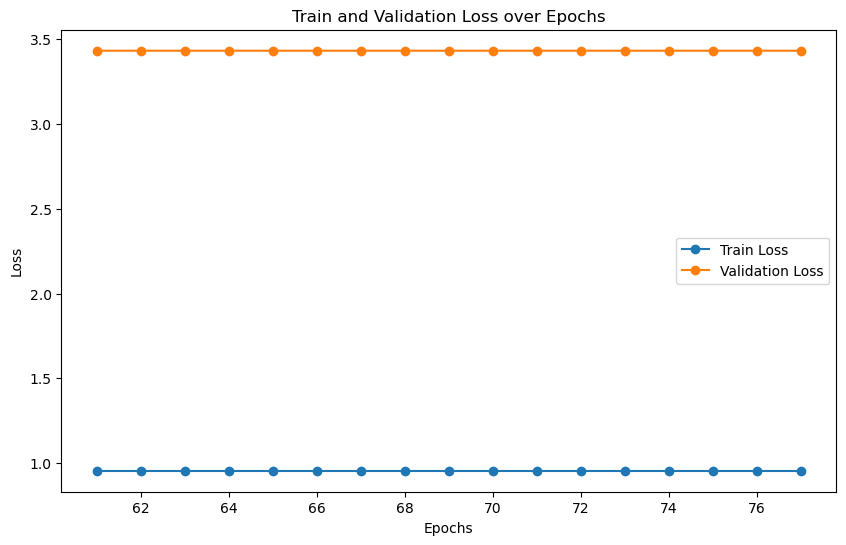

In [ ]:
# This is to show only part of the results in a chart

# Parameter configuration for loss filtering
# 'filter' indicates whether filters have to be applied to the lists of losses
filter = True
# Parameters specify the epoch range and the maximum value for a loss to be kept
max_value = 50
min_epoch = 60
max_epoch = 200

if filter:
    # Applying the filter to obtain loss lists that fit the constraints
    train_loss_list_fil, val_loss_list_fil = filter_lists(train_loss_list, val_loss_list, max_value, min_epoch, max_epoch)
    epochs_range = range(min_epoch + 1, min_epoch + 1 + len(train_loss_list_fil))
else:
    # If filtering is off, use the original loss lists
    train_loss_list_fil, val_loss_list_fil = train_loss_list, val_loss_list
    epochs_range = range(1, len(train_loss_list_fil) + 1)

# Creating the graph
plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_loss_list_fil, label='Train Loss', marker='o')
plt.plot(epochs_range, val_loss_list_fil, label='Validation Loss', marker='o')
# Adding title and labels
plt.title('Train and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Save model

In [ ]:
if (drive):
    save_model_path = f'/content/drive/My Drive/TFM/models/model-{generate_id()[:12]}.pth'
    results_path = f'/content/drive/My Drive/TFM/models/model-{generate_id()[:12]}.pth'
else:
    save_model_path = os.path.join(main_dir, "models", f'model-{generate_id()[:12]}.pth')
    results_path = os.path.join(main_dir, "results", f'results-{generate_id()[:12]}.json')

print(save_model_path)
print(results_path)

/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/models/model-202407042057.pth
/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202407042057.json


In [ ]:
#torch.save(model.state_dict(), save_model_path)

# Creating a dictionary with lists
data = {
    'train_loss_list': train_loss_list,
    'val_loss_list': val_loss_list,
    'MAE': f"{MAE:.4f}",
    'MAPE': f"{MAPE:.2f}%",
    'RMSE': f"{RMSE:.4f}",
}

# Save to a JSON file
with open(results_path, 'w') as json_file:
    json.dump(data, json_file, indent=4)

# Load Best Model

In [ ]:
model_id = 202407032036
# 202407012024

drive = False
if (drive):
    load_path = f'/content/drive/My Drive/TFM/models/model-{model_id}.pth'
else:
    load_path = os.path.join(main_dir, "models", f'model-{model_id}.pth')

print(load_path)

model = STGCN(Ks, Kt, blocks, n_his, n_route, Lk, drop_prob).to(device)
state_dict = torch.load(load_path)
model.load_state_dict(state_dict)
type(model)

/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/models/model-202407032036.pth


__main__.STGCN

# Prediction

In [ ]:
model.eval()

# (back-propagation is not needed here)
with torch.no_grad():
    # Inicializing lists to store error metrics
    mae, mape, mse = [], [], []

    # Iterating on training data
    for x, y in test_iter:
        x_raw = x # Store original input data
        y_raw = y # Store original labels

        # Transforming ground labels to their original scale
        y = scaler.inverse_transform(y.cpu().numpy()).reshape(-1)

        # Running model prediction and transforming to original scale
        y_pred = scaler.inverse_transform(model(x).view(len(x), -1).cpu().numpy()).reshape(-1)

In [ ]:
# Returns the index and column where the value is found
def search_value_in_dataframe(df, value):
    result = []  

    for col in df.columns:
        matching_rows = df[df[col] == value].index.tolist()

        for row in matching_rows:
            result.append((row, col))

    return result  

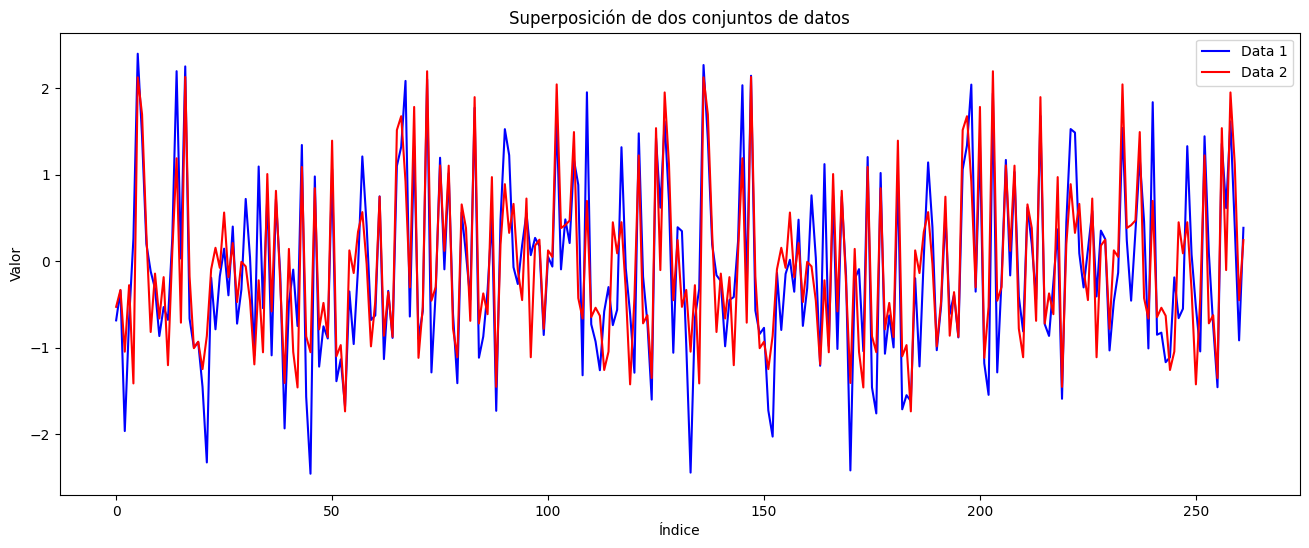

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Ground and predicted values
data1 = y
data2 = y_pred

# Creating a figure
plt.figure(figsize=(16, 6))

# Showing the first data set
plt.plot(data1, label='Data 1', color='b')

# Showing the second data set over the first
plt.plot(data2, label='Data 2', color='r')

# Add title and labels
plt.title('Overlapping of two data sets')
plt.xlabel('Index')
plt.ylabel('Value')

plt.legend()

plt.show()

In [ ]:
len(y)

262

### Predictions for 2020

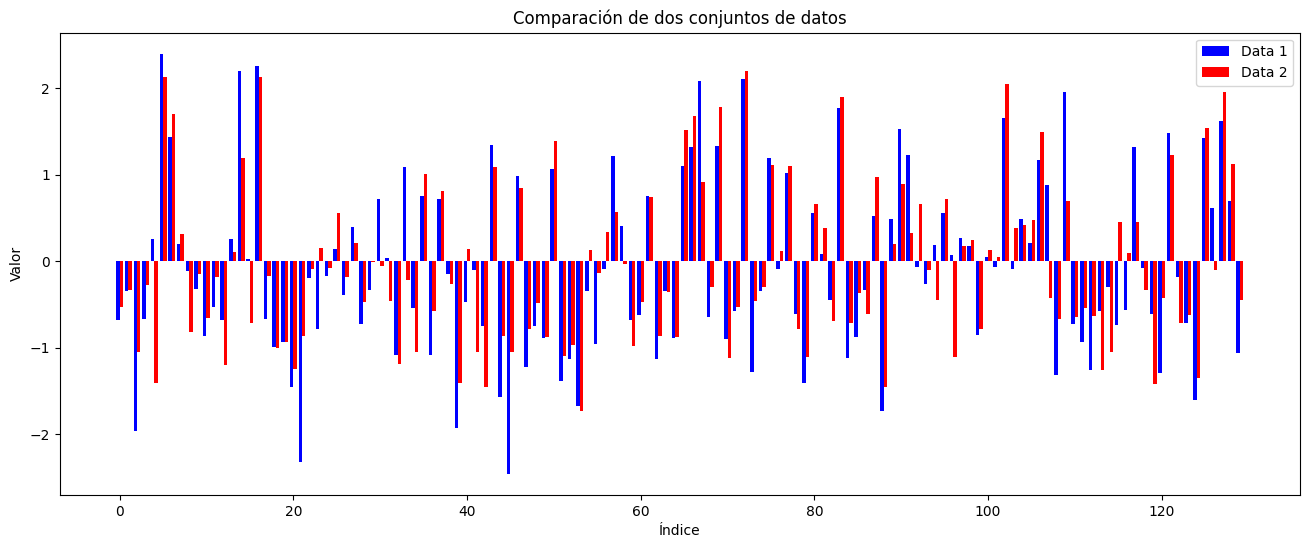

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Selecting a year (131 countries, columns) for input data and predictions
data1 = y[:130] 
data2 = y_pred[:130]  

# Creating a figure
plt.figure(figsize=(16, 6))

# Defining the index for bars
indices = np.arange(len(data1))

# Bar width
width = 0.4

# Show the first data set as bars
plt.bar(indices - width/2, data1, width=width, label='Data 1', color='blue')

# Show the first data set as bars
plt.bar(indices + width/2, data2, width=width, label='Data 2', color='red')

plt.title('Comparing two data sets')
plt.xlabel('Index')
plt.ylabel('Value')

plt.legend()

plt.show()

In [ ]:
list(matrix_df.columns)[2]

'ALB'

In [ ]:
list(matrix_df.columns)[61]

'IRQ'

In [ ]:
# Calcular la diferencia absoluta entre los valores correspondientes
diferencias = np.abs(data1[:130] - data2[:130])

# Encontrar la posición con la mayor diferencia
posicion_max_diferencia = np.argmax(diferencias)
mayor_diferencia = diferencias[posicion_max_diferencia]

print(f"La posición con la mayor diferencia es: {posicion_max_diferencia}")
print(f"La mayor diferencia es: {mayor_diferencia}")
varianza = np.var(data_df['ALB'])
varianza

La posición con la mayor diferencia es: 4
La mayor diferencia es: 1.6713793277740479


0.061128118061207194

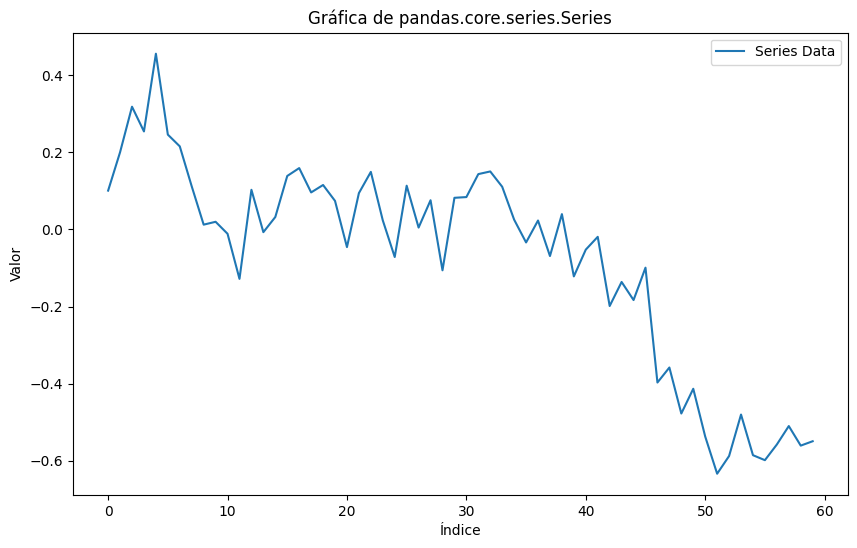

In [ ]:
type(data_df['AUS'])

plt.figure(figsize=(10, 6))
plt.plot(data_df['AUS'], label='Series Data')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Gráfica de pandas.core.series.Series')
plt.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
# Calcular la diferencia absoluta entre los valores correspondientes
diferencias = np.abs(data1 - data2)

# Encontrar la posición con la mayor diferencia
posicion_max_diferencia = np.argmax(diferencias)
mayor_diferencia = diferencias[posicion_max_diferencia]

print(f"El pais con la mayor diferencia es: {list(matrix_df.columns)[posicion_max_diferencia]}")
print(f"La mayor diferencia es: {mayor_diferencia}")


El pais con la mayor diferencia es: AUS
La mayor diferencia es: 1.6713793277740479


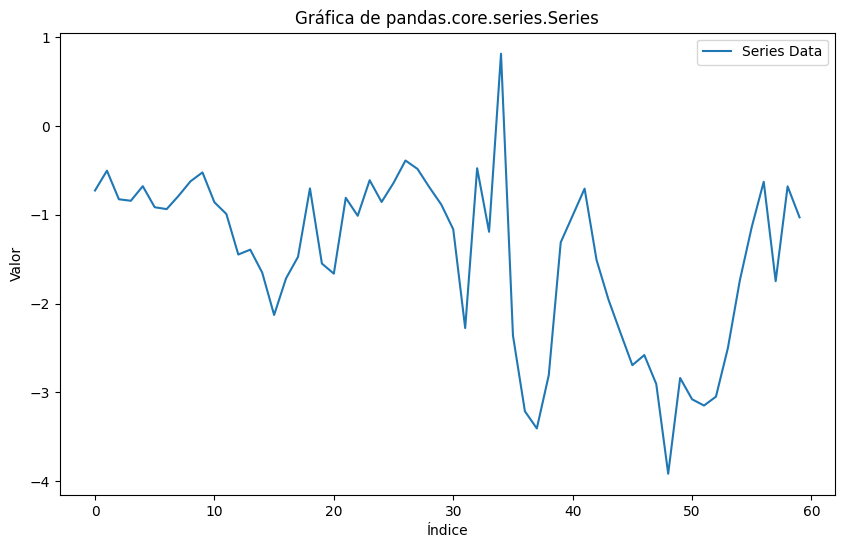

In [ ]:
type(data_df['IRQ'])

plt.figure(figsize=(10, 6))
plt.plot(data_df['IRQ'], label='Series Data')
plt.xlabel('Índice')
plt.ylabel('Valor')
plt.title('Gráfica de pandas.core.series.Series')
plt.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
data_df = pd.read_csv(data_path)

In [ ]:
data = data.drop(columns=['year'])

In [ ]:
y_1 = y[:131]
y_2 = y[131:]

y_pred_1 = y_pred[:131]
y_pred_2 = y_pred[:131]

In [ ]:
results_2020 = pd.DataFrame([y_1, y_pred_1], columns=data.columns)
results_2021 = pd.DataFrame([y_2, y_pred_2], columns=data.columns)

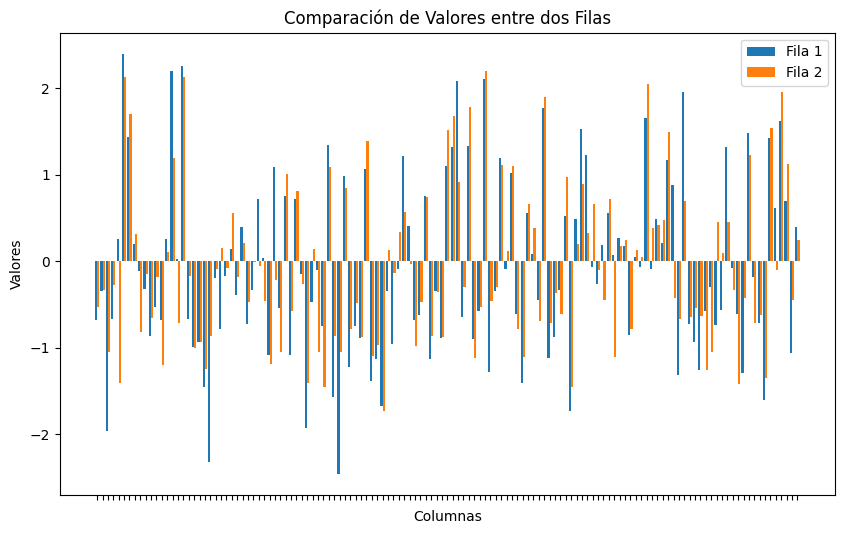

In [ ]:
fila_1 = results_2020.iloc[0]  # Primera fila
fila_2 = results_2020.iloc[1]  # Segunda fila

# Configurar los valores de las dos filas
valores_fila_1 = fila_1.values
valores_fila_2 = fila_2.values

labels = fila_1.index

# Crear la gráfica de barras
x = range(len(labels))
width = 0.4  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))  # Ajustar el tamaño de la figura si es necesario
ax.bar(x, valores_fila_1, width=width, label='Fila 1', align='center')
ax.bar([p + width for p in x], valores_fila_2, width=width, label='Fila 2', align='center')

# Añadir etiquetas y título
ax.set_xlabel('Columnas')
ax.set_ylabel('Valores')
ax.set_title('Comparación de Valores entre dos Filas')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels([''] * len(labels))  # Configurar las etiquetas del eje x como vacías
ax.legend()

# Mostrar la gráfica
plt.show()


### predicts 2021

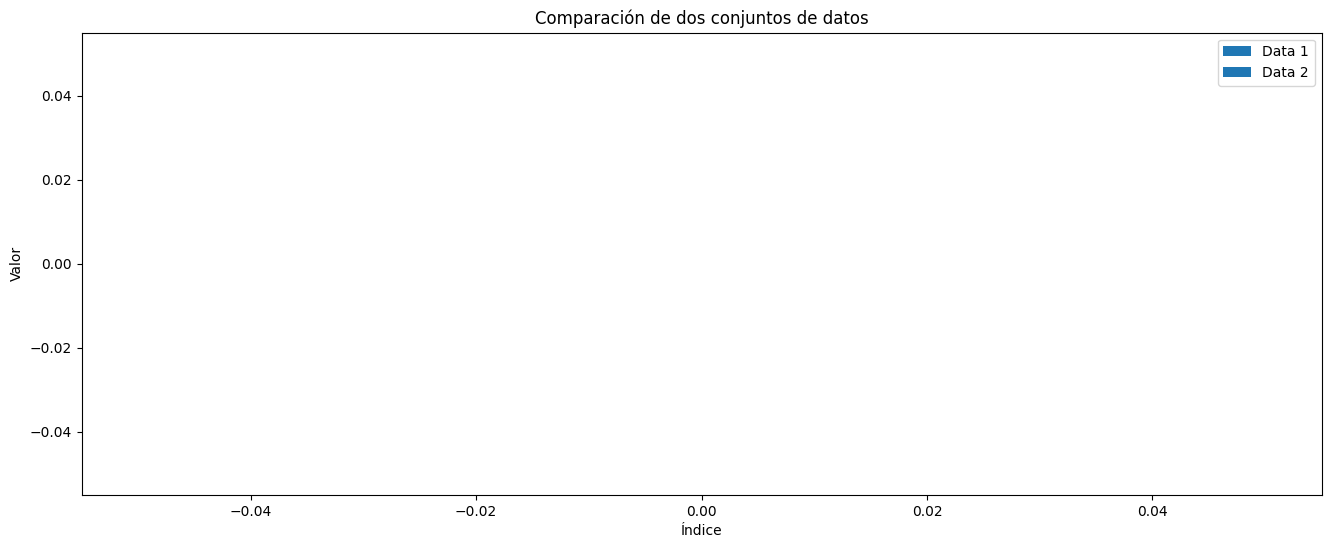

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Supongamos que tienes dos numpy arrays de ejemplo
data1 = y[131:]  # Ejemplo de datos aleatorios
data2 = y_pred[131:]  # Ejemplo de datos aleatorios

# Crear una figura y un conjunto de ejes
plt.figure(figsize=(16, 6))

# Definir el índice para las barras
indices = np.arange(len(data1))

# Ancho de las barras
width = 0.4

# Graficar el primer conjunto de datos como barras
plt.bar(indices - width/2, data1, width=width, label='Data 1', color='b')

# Graficar el segundo conjunto de datos como barras
plt.bar(indices + width/2, data2, width=width, label='Data 2', color='r')

# Añadir título y etiquetas
plt.title('Comparación de dos conjuntos de datos')
plt.xlabel('Índice')
plt.ylabel('Valor')

# Añadir una leyenda
plt.legend()

# Mostrar el gráfico
plt.show()


In [ ]:
list(matrix_df.columns)[4]

'AUS'

In [ ]:
data1 = y[131:]
data2 = y_pred[131:]

In [ ]:
# Calcular la diferencia absoluta entre los valores correspondientes
diferencias = np.abs(data1 - data2)

# Encontrar la posición con la mayor diferencia
posicion_max_diferencia = np.argmax(diferencias)
mayor_diferencia = diferencias[posicion_max_diferencia]

print(f"El pais con la mayor diferencia es: {list(matrix_df.columns)[posicion_max_diferencia]}")
print(f"La mayor diferencia es: {mayor_diferencia}")
print( f"Varianza de {list(matrix_df.columns)[posicion_max_diferencia]} : {np.var(data_df[list(matrix_df.columns)[posicion_max_diferencia]])}")

El pais con la mayor diferencia es: ALB
La mayor diferencia es: 1.3962376117706299
Varianza de ALB : 0.061128118061207194


In [ ]:
varianza = np.var(data_df[list(matrix_df.columns)[posicion_max_diferencia]])
print( f"Varianza de {list(matrix_df.columns)[posicion_max_diferencia]} : {}")

0.061128118061207194

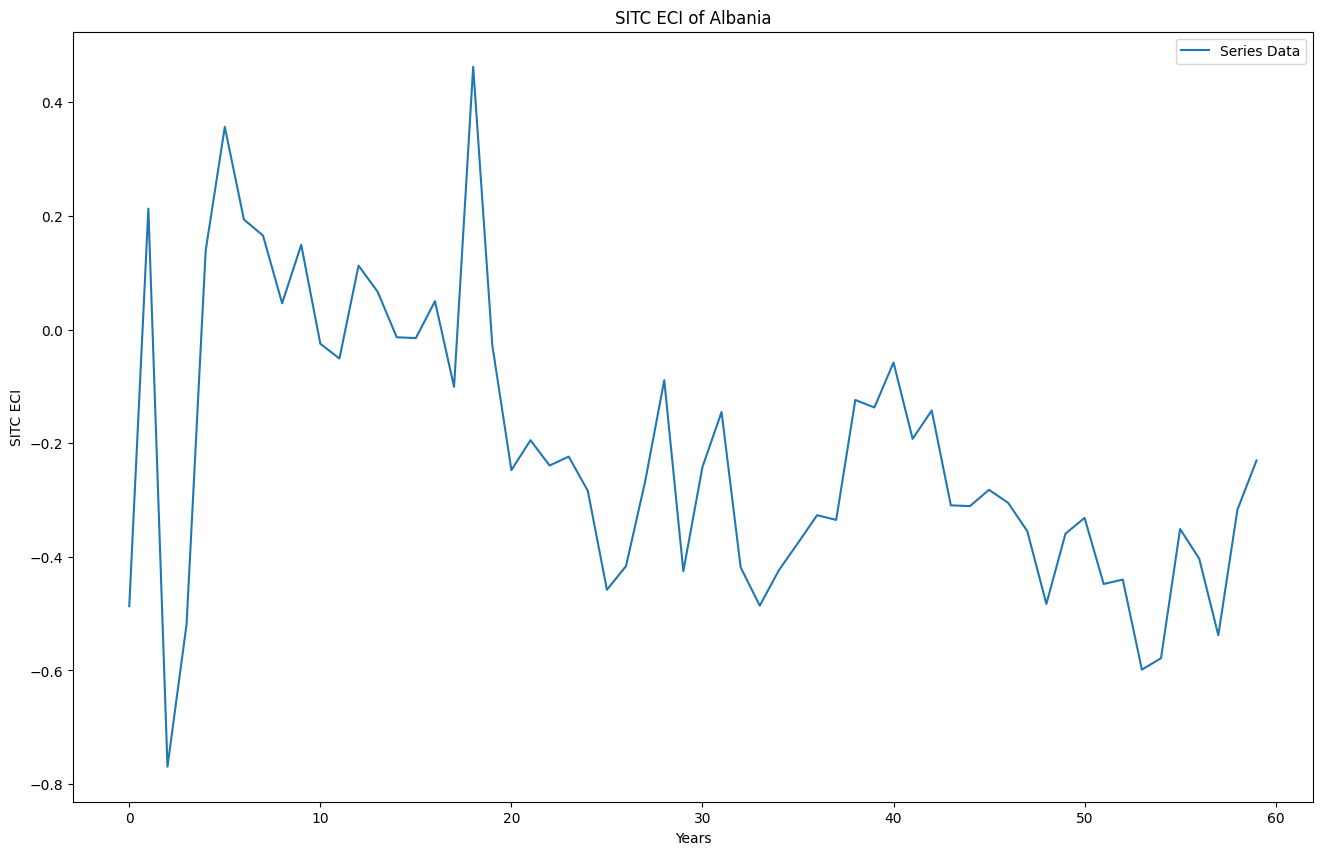

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(data_df['ALB'], label='Series Data')
plt.xlabel('Years')
plt.ylabel('SITC ECI')
plt.title('SITC ECI of Albania')
plt.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
# Calcular la diferencia absoluta entre los valores correspondientes
diferencias = np.abs(data1 - data2)

# Encontrar la posición con la mayor diferencia
posicion_max_diferencia = np.argmin(diferencias)
mayor_diferencia = diferencias[posicion_max_diferencia]

print(f"El pais con la menor diferencia es: {list(matrix_df.columns)[posicion_max_diferencia]}")
print(f"La menor diferencia es: {mayor_diferencia}")
print( f"Varianza de {list(matrix_df.columns)[posicion_max_diferencia]} : {np.var(data_df[list(matrix_df.columns)[posicion_max_diferencia]])}")

El pais con la menor diferencia es: PHL
La menor diferencia es: 0.0067242830991744995
Varianza de PHL : 0.12285973089026177


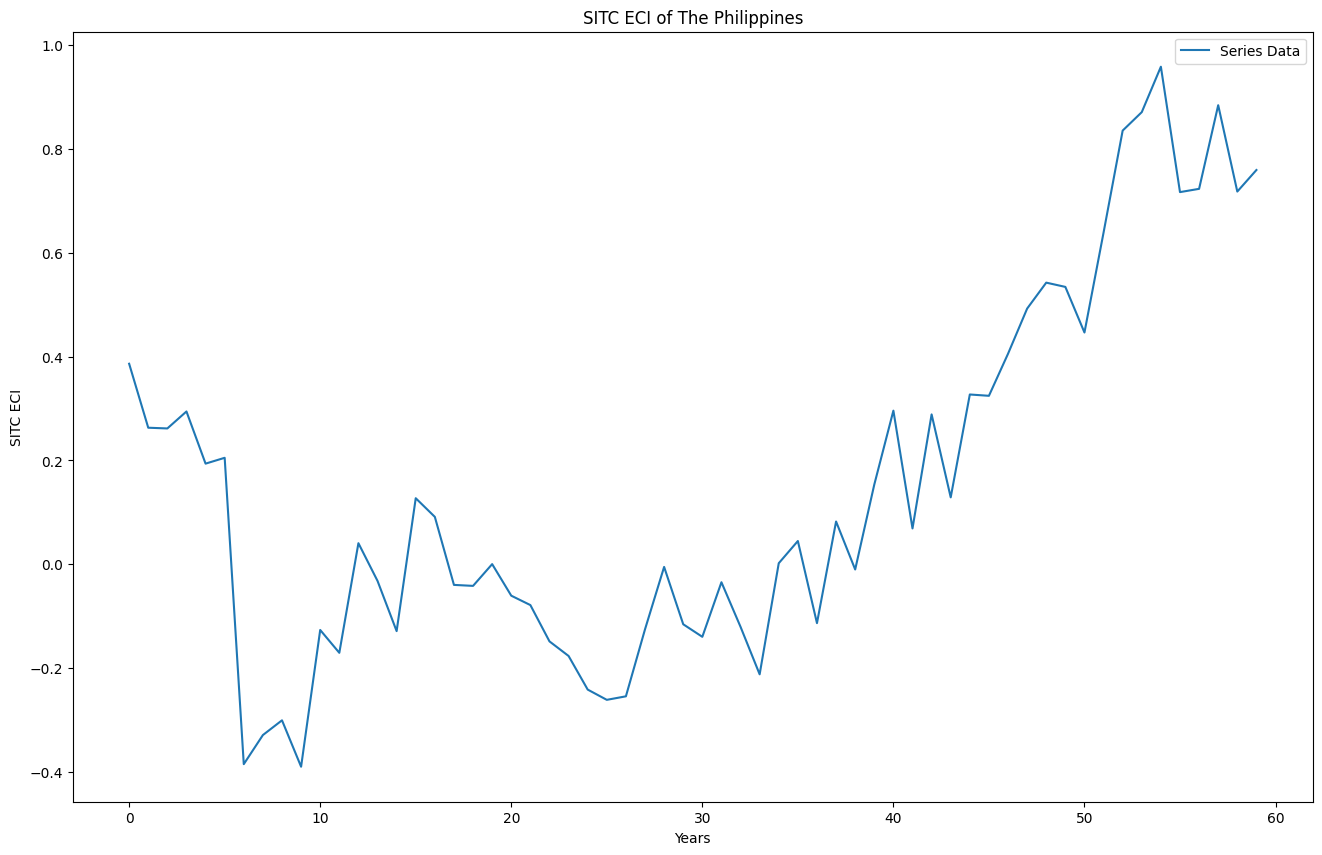

In [ ]:
plt.figure(figsize=(16, 10))
plt.plot(data_df['PHL'], label='Series Data')
plt.xlabel('Years')
plt.ylabel('SITC ECI')
plt.title('SITC ECI of The Philippines')
plt.legend()

# Mostrar la gráfica
plt.show()

In [ ]:
data_df = pd.read_csv(data_path)

In [ ]:
data = data.drop(columns=['year'])

In [ ]:
y_1 = y[:131]
y_2 = y[131:]

y_pred_1 = y_pred[:131]
y_pred_2 = y_pred[:131]

In [ ]:
results_2020 = pd.DataFrame([y_1, y_pred_1], columns=data.columns)
results_2021 = pd.DataFrame([y_2, y_pred_2], columns=data.columns)

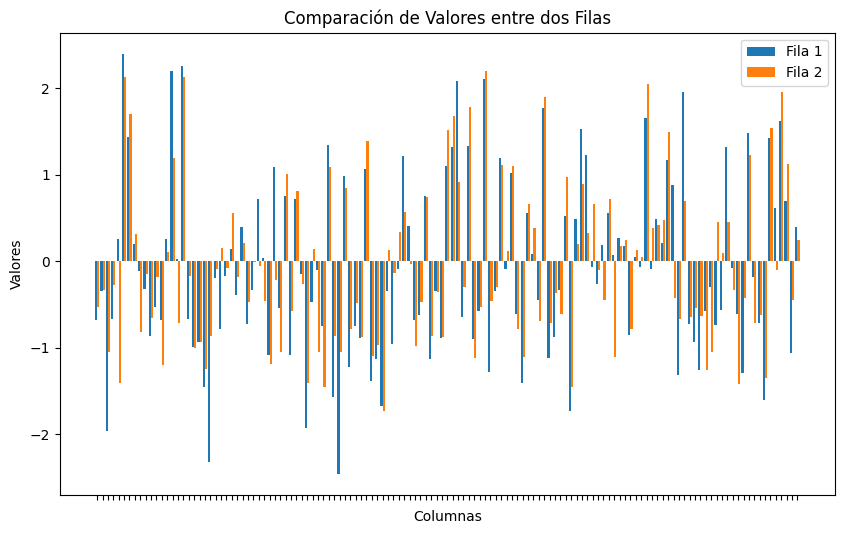

In [ ]:
fila_1 = results_2020.iloc[0]  # Primera fila
fila_2 = results_2020.iloc[1]  # Segunda fila

# Configurar los valores de las dos filas
valores_fila_1 = fila_1.values
valores_fila_2 = fila_2.values

labels = fila_1.index

# Crear la gráfica de barras
x = range(len(labels))
width = 0.4  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))  # Ajustar el tamaño de la figura si es necesario
ax.bar(x, valores_fila_1, width=width, label='Fila 1', align='center')
ax.bar([p + width for p in x], valores_fila_2, width=width, label='Fila 2', align='center')

# Añadir etiquetas y título
ax.set_xlabel('Columnas')
ax.set_ylabel('Valores')
ax.set_title('Comparación de Valores entre dos Filas')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels([''] * len(labels))  # Configurar las etiquetas del eje x como vacías
ax.legend()

# Mostrar la gráfica
plt.show()


### countries study

In [ ]:
matrix_columns = list(matrix_df.columns)

In [ ]:
def n_closest_countries(df, country, N):
    distances = df[country]
    sorted_distances = distances.sort_values()
    closest_indices = sorted_distances.index[1:N+1]  # Skip the first one as it is the country itself
    closest_countries = [matrix_columns[i] for i in closest_indices]
    return closest_countries

def n_farthest_countries(df, country, N):
    distances = df[country]
    sorted_distances = distances.sort_values(ascending=False)
    farthest_indices = sorted_distances.index[:N]
    farthest_countries = [matrix_columns[i] for i in farthest_indices]
    return farthest_countries

def calcular_varianza(df, columna, previous_n=60):
    varianza = df[columna][:previous_n].var()
    return varianza


In [ ]:
def get_data_countries(country_name, N=5):
    # Calcular la varianza para cada uno de los países más cercanos y calcular la media de estas varianzas
    closest_countries = n_closest_countries(matrix_df, country_name, N)
    varianzas = [calcular_varianza(data_df, country, 10) for country in closest_countries]
    media_varianzas = np.mean(varianzas)

    print(f"Los {N} países más cercanos a {country_name} son: {closest_countries}")
    print(f"La varianza de cada uno de estos paíse de los ultimos 10 años es: {[round(v, 4) for v in varianzas]}")
    print(f"La media de las varianzas es: {round(media_varianzas, 4)}")

    # Calcular la varianza para cada uno de los países más cercanos y calcular la media de estas varianzas
    farthest_countries = n_farthest_countries(matrix_df, country_name, N)
    varianzas = [calcular_varianza(data_df, country, 10) for country in farthest_countries]
    media_varianzas = np.mean(varianzas)

    print(f"Los {N} países más lejanos a {country_name} son: {farthest_countries}")
    print(f"La varianza de cada uno de estos países de los ultimos 10 años es: {[round(v, 4) for v in varianzas]}")
    print(f"La media de las varianzas es: {round(media_varianzas, 4)}")

    return closest_countries, farthest_countries

def represent_countries(countries, previous_n=10):
  # Filtrar las columnas más cercanas
  filtered_df = data_df[countries][:previous_n]

  # Crear la gráfica
  plt.figure(figsize=(14, 8))

  # Graficar cada columna
  for column in filtered_df.columns:
      plt.plot(filtered_df.index, filtered_df[column], label=column)

  # Añadir título y etiquetas
  plt.title('Valores de las columnas más cercanas')
  plt.xlabel('Índice')
  plt.ylabel('Valor')

  # Añadir una leyenda
  plt.legend()

  # Mostrar la gráfica
  plt.show()

In [ ]:
closest_countries, farthest_countries = get_data_countries('ALB')

Los 5 países más cercanos a ALB son: ['GRC', 'BGR', 'ITA', 'HUN', 'MLT']
La varianza de cada uno de estos paíse de los ultimos 10 años es: [0.0425, 0.0348, 0.0026, 0.0094, 0.006]
La media de las varianzas es: 0.0191
Los 5 países más lejanos a ALB son: ['NZL', 'WSM', 'FJI', 'NCL', 'VUT']
La varianza de cada uno de estos países de los ultimos 10 años es: [0.0042, 0.1646, 0.1128, 0.1446, 0.0482]
La media de las varianzas es: 0.0949


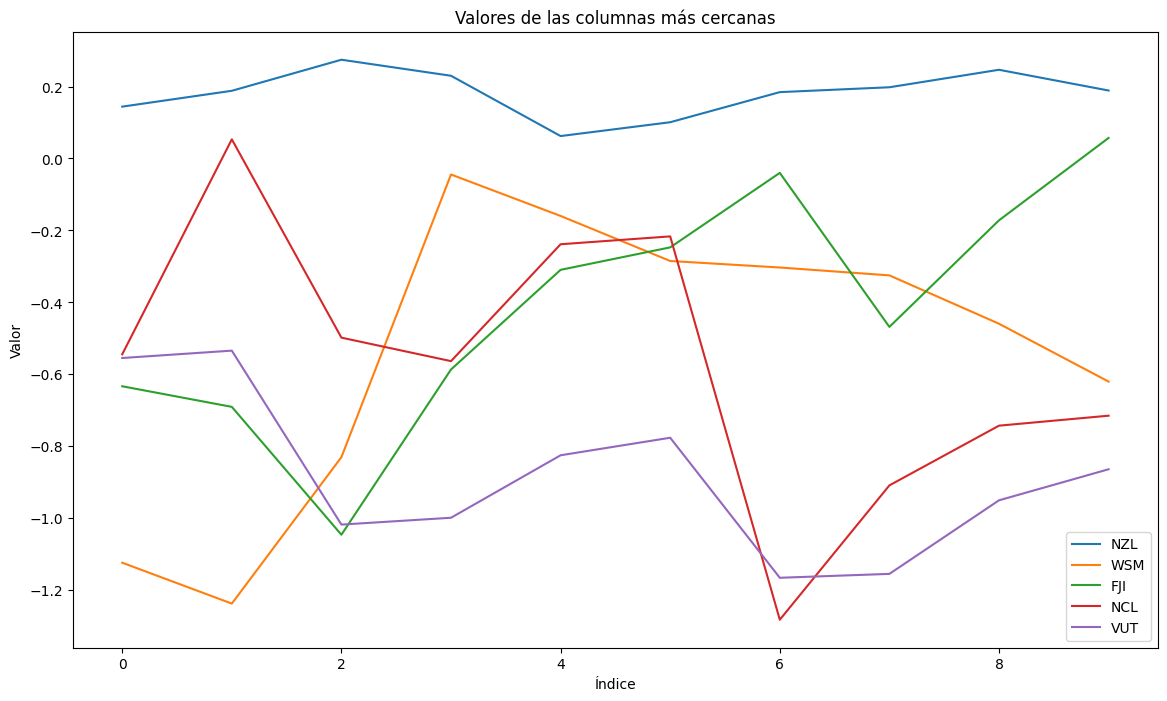

In [ ]:
represent_countries(farthest_countries)

# Comparación modelos

## Load results

In [ ]:
regular_data = "results-20240630"
inverted_matrix = "results-20240701"

results_main_path = '/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results'

### List files

In [ ]:
import os

def list_files(carpeta, prefijo):
    # Lista para almacenar los paths de los archivos que cumplen con el criterio
    archivos_filtrados = []

    # Iterar sobre los archivos en la carpeta
    for archivo in os.listdir(carpeta):
        # Comprobar si el archivo comienza con el prefijo especificado
        if archivo.startswith(prefijo):
            # Crear el path completo del archivo y añadirlo a la lista
            path_completo = os.path.join(carpeta, archivo)
            archivos_filtrados.append(path_completo)

    return archivos_filtrados

result_list = list_files(results_main_path, regular_data)

# Imprimir los paths de los archivos que cumplen con el criterio
for result_file in result_list:
    print(result_file)


/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301155.json
/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301204.json
/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301208.json
/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301214.json
/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301220.json


In [ ]:
results_dict = {
    "AdamW - CosineAnnealingLR": result_list[0],
    "RMSprop - CosineAnnealingLR": result_list[1],
    "AdamW -CosineAnnealingLR": result_list[2],
    "AdamW -CosineAnnealingLR": result_list[3],
}

['/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301155.json',
 '/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301204.json',
 '/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301208.json',
 '/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301214.json',
 '/mnt/e/ARCHIVOS/UNIVERSIDAD/MUIA/TFM/Development/stgcn-colab/results/results-202406301220.json']

### Enum files and search

In [ ]:
def leer_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def leer_result(file_path):
    file_path = f'{results_main_path}/results-{file_path}.json'
    return leer_json(file_path)

def get_results_data(model_dict):
    for key, value in model_dict.items():
        # Leer el archivo JSON correspondiente usando el "id"
        json_data = leer_result(value["id"])

        # Añadir los datos del JSON al diccionario bajo la misma clave
        model_dict[key].update(json_data)

    return model_dict

In [ ]:
regular_data_dict = {
    0: {"name": "AdamW - CosineAnnealingLR", "id": 202407032033},
    1: {"name": "RMSprop - CosineAnnealingLR", "id": 202407042014},
    2: {"name": "RMSprop - StepLR", "id": 202407032036},
    3: {"name": "AdamW - StepLR", "id": 202407032034},
}

inverted_matrix_dict = {
    1: {"name": "RMSprop - CosineAnnealingLR", "id": 202407032058},
    2: {"name": "RMSprop - StepLR", "id": 202407032056},
}

exp_inverted_matrix_dict = {
    1: {"name": "RMSprop - CosineAnnealingLR", "id": 202407032106},
    2: {"name": "RMSprop - StepLR", "id": 202407032107},
}

## Grafico

In [ ]:
results_data = get_results_data(regular_data_dict)

regular_result_loss = leer_result('202407042014')['val_loss_list']
inverted_result_loss = leer_result('202407032058')['val_loss_list']
exp_inverted_result_loss = leer_result('202407032106')['val_loss_list']
exp_inverted_loss_expanded = leer_result('202407042053')['val_loss_list']
exp_inverted_loss_expanded_v2 = leer_result('202407042053')['val_loss_list']

### Listas de loss

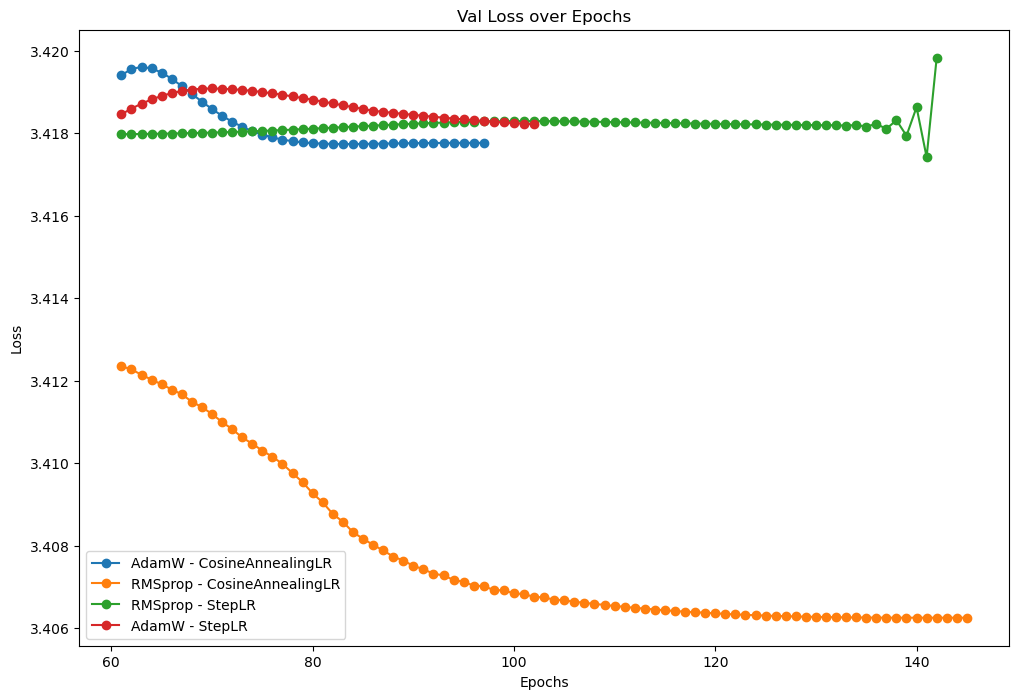

In [ ]:
# Filtrar
    # True | False
filtrar = True
max_value = 3.5
min_epoch = 60
max_epoch = 200
# 'train_loss_list' | 'val_loss_list'
loss_list_name = 'val_loss_list'

# Crear la gráfica
plt.figure(figsize=(12, 8))

for key, value in results_data.items():
    loss_list = value[loss_list_name]

    if(filtrar):
        loss_list_fil = filtrar_valores_lista(loss_list, max_value, min_epoch, max_epoch)
        epochs_range = range(min_epoch + 1, min_epoch + 1 + len(loss_list_fil))
    else:
        loss_list_fil = loss_list
        epochs_range = range(1, len(loss_list_fil) + 1)

    name = value['name']
    plt.plot(epochs_range, loss_list_fil, label=name, marker='o')

# Añadir títulos y etiquetas
plt.title('Val Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Métricas

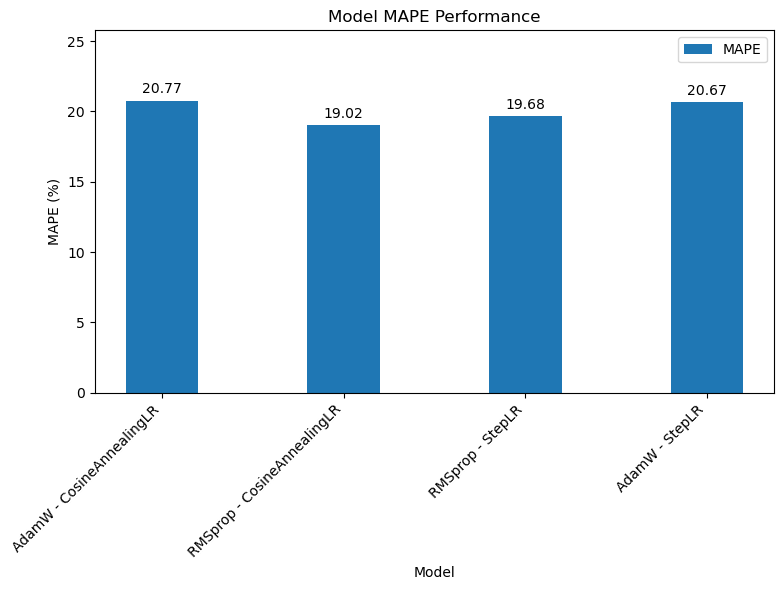

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Recopilar los valores de MAPE
model_names = []
mape_values = []

for key, value in results_data.items():
    model_names.append(value['name'])
    mape_values.append(float(value['MAPE'].strip('%')))

# Configurar la posición de las barras
x = np.arange(len(model_names))
width = 0.4  # Ancho de las barras

# Crear la gráfica
fig, ax = plt.subplots(figsize=(8, 6))

# Añadir las barras para MAPE
rects = ax.bar(x, mape_values, width, label='MAPE')

# Añadir etiquetas y títulos
ax.set_xlabel('Model')
ax.set_ylabel('MAPE (%)')
ax.set_title('Model MAPE Performance')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()

# Ajustar el límite superior del eje y para dar más margen
max_height = max(mape_values)
ax.set_ylim(0, max_height + 5)  # Añade un margen del 5% sobre el valor máximo

# Añadir los valores encima de las barras
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


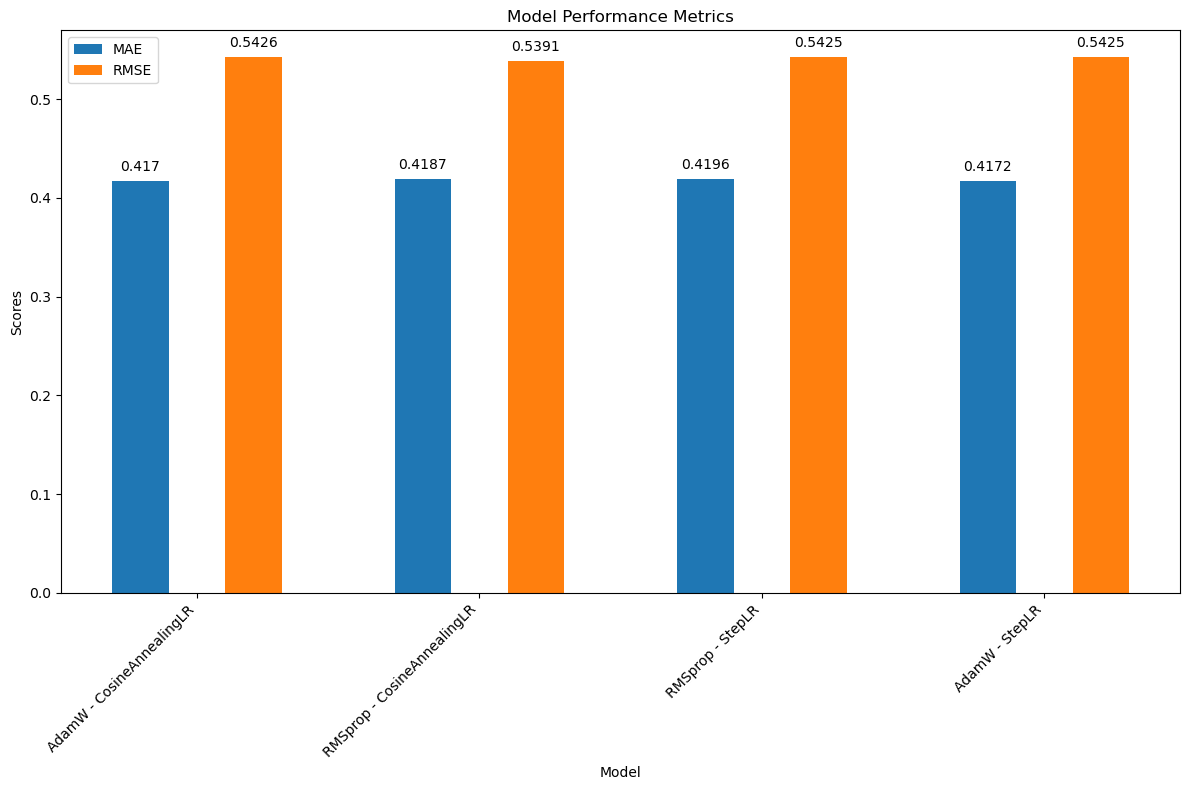

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Recopilar los valores de MAE, MAPE y RMSE
model_names = []
mae_values = []
mape_values = []
rmse_values = []

for key, value in results_data.items():
    model_names.append(value['name'])
    mae_values.append(float(value['MAE']))
    rmse_values.append(float(value['RMSE']))

# Configurar la posición de las barras
x = np.arange(len(model_names))
width = 0.2  # Ancho de las barras

# Crear la gráfica
fig, ax = plt.subplots(figsize=(12, 8))

# Añadir las barras para MAE, MAPE y RMSE
rects1 = ax.bar(x - width, mae_values, width, label='MAE')
rects3 = ax.bar(x + width, rmse_values, width, label='RMSE')

# Añadir etiquetas y títulos
ax.set_xlabel('Model')
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()

# Añadir los valores encima de las barras
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 5)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects3)

# Mostrar la gráfica
plt.tight_layout()
plt.show()


### All data types

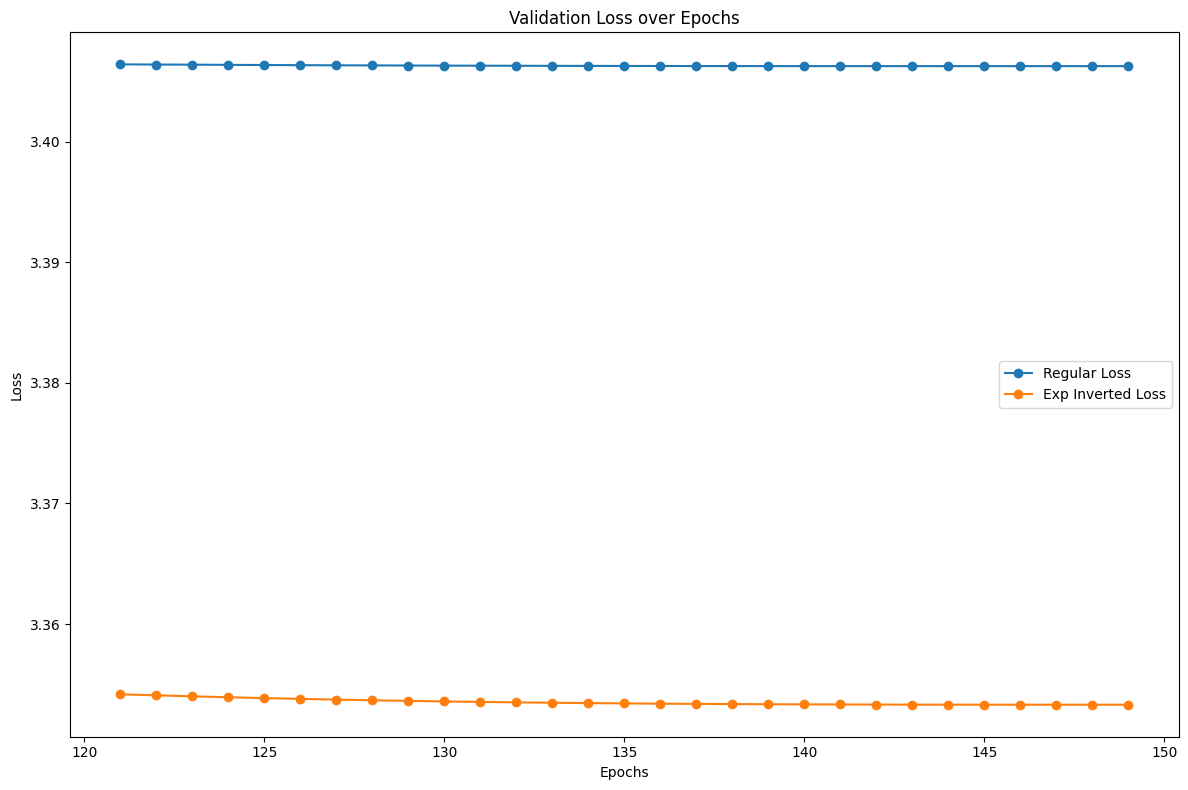

In [ ]:
# Parámetros de filtrado
# False | True
filtrar = True
max_value = 1000
min_epoch = 10
max_epoch = 150

# Filtrar las listas de resultados si es necesario
if filtrar:
    regular_result_loss_fil = filtrar_valores_lista(regular_result_loss, max_value, min_epoch, max_epoch)
    inverted_result_loss_fil = filtrar_valores_lista(inverted_result_loss, max_value, min_epoch, max_epoch)
    exp_inverted_result_loss_fil = filtrar_valores_lista(exp_inverted_result_loss, max_value, min_epoch, max_epoch)
else:
    regular_result_loss_fil = regular_result_loss
    inverted_result_loss_fil = inverted_result_loss
    exp_inverted_result_loss_fil = exp_inverted_result_loss

# Crear rangos de épocas correspondientes
epochs_range_regular = range(min_epoch + 1, min_epoch + 1 + len(regular_result_loss_fil))
# epochs_range_inverted = range(min_epoch + 1, min_epoch + 1 + len(inverted_result_loss_fil))
epochs_range_exp_inverted = range(min_epoch + 1, min_epoch + 1 + len(exp_inverted_result_loss_fil))

# Crear la gráfica
plt.figure(figsize=(12, 8))

# Plotear los resultados
plt.plot(epochs_range_regular, regular_result_loss_fil, label='Regular Loss', marker='o')
# plt.plot(epochs_range_inverted, inverted_result_loss_fil, label='Inverted Loss', marker='o')
plt.plot(epochs_range_exp_inverted, exp_inverted_result_loss_fil, label='Exp Inverted Loss', marker='o')

# Añadir títulos y etiquetas
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

In [ ]:
exp_inverted_loss_expanded = exp_inverted_loss_expanded_fil
exp_inverted_loss_expanded_v2 = val_loss_list

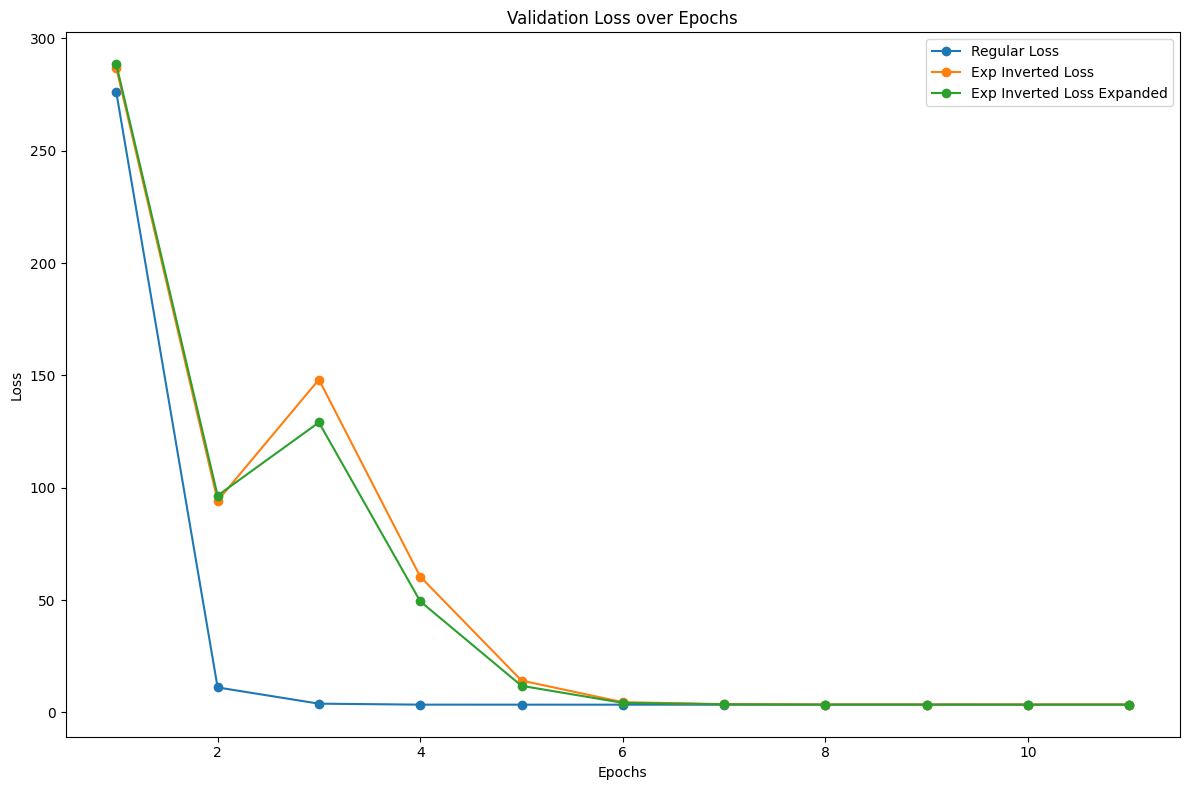

In [ ]:
# False | True
filtrar = True
max_value = 300
min_epoch = 0
max_epoch = 10

# Filtrar las listas de resultados si es necesario
if filtrar:
    regular_result_loss_fil = filtrar_valores_lista(regular_result_loss, max_value, min_epoch, max_epoch)
    # inverted_result_loss_fil = filtrar_valores_lista(inverted_result_loss, max_value, min_epoch, max_epoch)
    exp_inverted_result_loss_fil = filtrar_valores_lista(exp_inverted_result_loss, max_value, min_epoch, max_epoch)
    exp_inverted_loss_expanded_fil = filtrar_valores_lista(exp_inverted_loss_expanded, max_value, min_epoch, max_epoch)
    # exp_inverted_loss_expanded_v2_fil = filtrar_valores_lista(exp_inverted_loss_expanded_v2, max_value, min_epoch, max_epoch)
else:
    regular_result_loss_fil = regular_result_loss
    # inverted_result_loss_fil = inverted_result_loss
    exp_inverted_result_loss_fil = exp_inverted_result_loss
    exp_inverted_loss_expanded_fil = exp_inverted_loss_expanded
    # exp_inverted_loss_expanded_v2_fil = exp_inverted_loss_expanded_v2

# Crear rangos de épocas correspondientes
epochs_range_regular = range(min_epoch + 1, min_epoch + 1 + len(regular_result_loss_fil))
# epochs_range_inverted = range(min_epoch + 1, min_epoch + 1 + len(inverted_result_loss_fil))
epochs_range_exp_inverted = range(min_epoch + 1, min_epoch + 1 + len(exp_inverted_result_loss_fil))
epochs_range_exp_inverted_expanded = range(min_epoch + 1, min_epoch + 1 + len(exp_inverted_loss_expanded_fil))
# epochs_range_exp_inverted_expanded_v2 = range(min_epoch + 1, min_epoch + 1 + len(exp_inverted_loss_expanded_v2_fil))

# Crear la gráfica
plt.figure(figsize=(12, 8))

# Plotear los resultados
plt.plot(epochs_range_regular, regular_result_loss_fil, label='Regular Loss', marker='o')
# plt.plot(epochs_range_inverted, inverted_result_loss_fil, label='Inverted Loss', marker='o')
plt.plot(epochs_range_exp_inverted, exp_inverted_result_loss_fil, label='Exp Inverted Loss', marker='o')
plt.plot(epochs_range_exp_inverted_expanded, exp_inverted_loss_expanded_fil, label='Exp Inverted Loss Expanded', marker='o')
# plt.plot(epochs_range_exp_inverted_expanded_v2, exp_inverted_loss_expanded_v2_fil, label='Exp Inverted Loss 500', marker='o')

# Añadir títulos y etiquetas
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

### Data Explore

In [ ]:
# Ejemplo de matriz de distancias 2x2
distances = np.array([[1000, 8, 2],
                      [1, 3, 90]])

# Llamar a la función calculate_adjacency_matrix con la matriz de distancias de ejemplo
adjacency_matrix = calculate_adjacency_matrix(distances, sigma_squared=10, epsilon=0.5)

# Imprimir la matriz de adyacencia resultante
adjacency_matrix

array([[0.        , 0.        ],
       [0.90483742, 0.        ]])

In [ ]:
def search_value_in_dataframe(df, value):

    result = []

    for col in df.columns:
        matching_rows = df[df[col] == value].index.tolist()
        for row in matching_rows:
            result.append((row, col))
    return result

In [ ]:
data = pd.read_csv(data_path)
data.head()

year       COM       GUY       LBR       SEN       BRN       JPN       USA  \
0  1962 -0.344110  0.068288 -0.442236 -0.203830  0.193716  2.091124  2.072395   
1  1963 -0.138500 -0.112739 -0.764035 -0.198813 -1.363110  1.917151  2.034126   
2  1964 -1.421275 -0.130738 -0.604106 -0.484891 -0.469227  1.895972  2.039541   
3  1965 -1.312219 -0.209335 -0.565352 -0.422038 -1.309534  1.944695  2.066791   
4  1966 -1.334038 -0.376698 -0.523193 -0.147933 -0.461554  1.881980  2.018157   

        RUS       OMN  ...       IRL       SUR       BEN       COG       FIN  \
0  0.535564  0.003049  ...  1.172661 -0.182548  0.062017 -0.865575  1.125539   
1  0.316475  0.837160  ...  1.008410 -0.267773  0.264796 -0.654586  1.375939   
2  0.726326 -0.868269  ...  1.194336 -0.909445  0.085699 -1.230536  1.293779   
3  0.723283 -0.834009  ...  1.258328 -0.280529 -0.100788 -0.824339  1.331217   
4  0.638421 -0.669928  ...  1.140344 -0.320551 -0.284729 -1.181578  1.468790   

        TUR       GBR       NOR       NIC       CYP  
0 -0.704393  2.288769  1.365959 -1.075753  0.000652  
1 -0.769430  2.278447  1.231053 -1.057869 -0.131323  
2 -0.601434  2.227930  1.321681 -0.222088 -0.344254  
3 -0.715468  2.347121  1.216481  0.143597 -0.492979  
4 -0.682230  2.279568  1.301043  0.177704 -0.234378  

[5 rows x 132 columns]

In [ ]:
x_train_expl, y_train_expl = data_transform_explore(train_df, n_his, n_pred, device)
x_val_expl, y_val_expl = data_transform_explore(val_df, n_his, n_pred, device)
x_test_expl, y_test_expl = data_transform_explore(test_df, n_his, n_pred, device)

#### Train

In [ ]:
print(f'x_train size: {x_train_expl.shape}')
print(f'y_train size: {y_train_expl.shape}')

x_train size: torch.Size([24, 1, 10, 131])
y_train size: torch.Size([24, 131])


In [ ]:
search_value_in_dataframe(data, x_train_expl[23][0][0][0].item())

[(23, 'COM')]

In [ ]:
y_train_expl[0][0].item()

-0.20733918

In [ ]:
search_value_in_dataframe(data, y_train_expl[0][0].item())

[(11, 'COM')]